[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/biodatlab/deep-learning-skooldio/blob/master/03_handwritten_recognition_explore.ipynb)

## **Thai-digit handwritten classification with Pytorch: Exploration**

This notebook contains exploration of the "Thai-digit handwritten classification" including
- Customize model
    - Adding layers
    - Adding dropout layer
- Adding data augmentation

## **Download and clean the dataset from the repository**

- We have downloaded the data from https://github.com/kittinan/thai-handwriting-number by cloning the repository
- Remove files that have character mismatch (as suggested by the the creator)
- Then, we put the cleaned data at https://github.com/biodatlab/deep-learning-skooldio

In [1]:
!git clone https://github.com/biodatlab/deep-learning-skooldio

Cloning into 'deep-learning-skooldio'...
remote: Enumerating objects: 1943, done.
remote: Counting objects: 100% (237/237), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 1943 (delta 120), reused 204 (delta 105), pack-reused 1706
Receiving objects: 100% (1943/1943), 14.54 MiB | 6.38 MiB/s, done.
Resolving deltas: 100% (131/131), done.


After cloning the repository, check that `deep-learning-skooldio` should appear in the directory.

In [1]:
import os
import os.path as op
from glob import glob
from pathlib import Path
import random
from PIL import Image
from collections import Counter
from torch.utils.data import ConcatDataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
directory = "deep-learning-skooldio/"
paths = glob(op.join(directory, "thai-handwritten-dataset", "*", "*"))
num_samples = len(paths)
print("Number of samples", num_samples)

Number of samples 1750


In [3]:
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import shutil

train_paths, test_paths = train_test_split(paths, test_size=0.1, random_state=42)
for i in range(10):
    os.makedirs(f"data/train/{i}", exist_ok=True)
    os.makedirs(f"data/validation/{i}", exist_ok=True)

In [4]:
def copy_to_destination(src_paths, dst_path: str = "data/train/"):
    for path in tqdm(src_paths):
        path = Path(path)
        parent_dir = path.parent.name
        shutil.copy(path, op.join(dst_path, parent_dir, path.name))

In [5]:
copy_to_destination(train_paths, "data/train/")
copy_to_destination(test_paths, "data/validation/")

  0%|          | 0/1575 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

In [6]:
len(glob("data/train/*/*")), len(glob("data/validation/*/*"))

(1575, 175)

## **Create a custom dataset and a dataloader**

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd

In [8]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.ToTensor()
])

In [9]:
class ThaiDigitDataset(Dataset):
    def __init__(self, img_dir: str, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_labels = [(p, Path(p).parent.name) for p in glob(op.join(img_dir, "*", "*"))]

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image, label = self.img_labels[idx]
        label = int(label)
        image = Image.open(image)
        if self.transform:
            image = 1 - self.transform(image)
        return image, label

In [10]:
train_thaidigit_dataset = ThaiDigitDataset("data/train/", transform=transform)
val_thaidigit_dataset = ThaiDigitDataset("data/validation/", transform=transform)

In [11]:
train_loader = DataLoader(train_thaidigit_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_thaidigit_dataset, batch_size=16, shuffle=False)

## **Create the model**

In [12]:
import torch.nn as nn
import torch.nn.functional as F

class ThaiDigitNet(nn.Module):
    def __init__(self):
        super(ThaiDigitNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

## **Train the model**

In [13]:
# Create training loop function
def train(model, n_epochs, loss_function, optimizer, train_loader, validation_loader):
    training_logs = {"train_loss": [],  "train_acc": [], "val_loss": [], "val_acc": []}
    print("-"*80)
    for epoch in range(1, n_epochs+1):
        # training
        model.train()
        train_loss, correct = 0, 0
        for images, labels in train_loader:
            pred = model(images)
            loss = loss_function(pred, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            correct += (pred.argmax(1) == labels).float().sum().item()
        # save training logs
        training_logs["train_loss"].append(train_loss/ len(train_loader))
        training_logs["train_acc"].append(correct / len(train_loader.dataset))

        # validation
        model.eval()
        val_loss, correct = 0, 0
        for images, labels in validation_loader:
            pred = model(images)
            val_loss += loss_function(pred, labels).item()
            correct += (pred.argmax(1) == labels).float().sum().item()
        # save validation logs
        training_logs["val_loss"].append(val_loss/ len(val_loader))
        training_logs["val_acc"].append(correct / len(validation_loader.dataset))

        print(f"Epochs {epoch}".ljust(10), 
              f"train loss {training_logs['train_loss'][-1]:.5f}",
              f"train acc {training_logs['train_acc'][-1]:.5f}",

              f"val loss {training_logs['val_loss'][-1]:.5f}",
              f"val acc {training_logs['val_acc'][-1]:.5f}",
              )
        print("-"*80)
    return model, training_logs
        

In [14]:
n_epoch = 100

net = ThaiDigitNet() # Initialize the model
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
net, net_history = train(net, n_epoch, loss_fn, optimizer, train_loader, val_loader)

--------------------------------------------------------------------------------
Epochs 1   train loss 2.29033 train acc 0.12571 val loss 2.28256 val acc 0.12571
--------------------------------------------------------------------------------
Epochs 2   train loss 2.25764 train acc 0.20000 val loss 2.25016 val acc 0.22857
--------------------------------------------------------------------------------
Epochs 3   train loss 2.21584 train acc 0.26603 val loss 2.20630 val acc 0.29714
--------------------------------------------------------------------------------
Epochs 4   train loss 2.16312 train acc 0.36000 val loss 2.14896 val acc 0.35429
--------------------------------------------------------------------------------
Epochs 5   train loss 2.09564 train acc 0.40825 val loss 2.08063 val acc 0.35429
--------------------------------------------------------------------------------
Epochs 6   train loss 2.01866 train acc 0.41968 val loss 1.99693 val acc 0.48571
----------------------------

In [15]:
def plot_graph(history):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(10)
    fig.suptitle("Train vs Validation")
    ax1.plot(history["train_acc"], label="Train")
    ax1.plot(history["val_acc"], label="Validation")
    ax1.legend()
    ax1.set_title("Accuracy")

    ax2.plot(history["train_loss"], label="Train")
    ax2.plot(history["val_loss"], label="Validation")
    ax2.legend()
    ax2.set_title("Loss")
    fig.show()

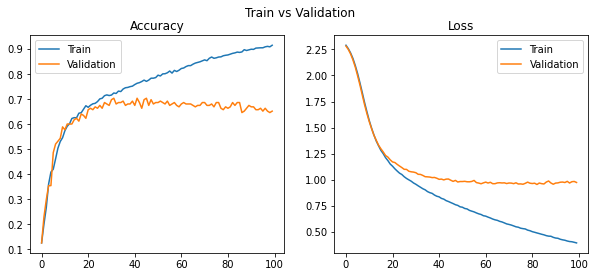

In [16]:
plot_graph(net_history)

We can observe "overfitting" as the model learns to predict the training set well but perform worse in validation set

## **Save and load model**



In [17]:
save_path = "thai_digit.pth"
torch.save(net.state_dict(), save_path)  # save model parameters

In [18]:
model_path = "thai_digit.pth"
model = ThaiDigitNet()  # initialize the model
model.load_state_dict(torch.load(model_path))  # load the model weights

<All keys matched successfully>

## **Evaluate the model**

In [19]:
# Create evaluation function for the model
def evaluate(val_dir, model):
    model.eval()
    paths = glob(op.join(val_dir, "*", "*"))
    predictions = []
    for idx, path in enumerate(paths):
        img = 1 - transform(Image.open(path))
        pred = model(img)
        predictions.append({
            "path": path,
            "prediction": int(pred.argmax(dim=1).item()),
            "label": int(Path(path).parent.name)
        })

    results = pd.DataFrame(predictions)
    # Calculate accuracy
    accuracy = (results.prediction == results.label).sum() / len(results)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    return results

In [20]:
pred_df = evaluate("data/validation/", model)
pred_df.head(3)

Accuracy: 65.14%


,path,prediction,label
0,data/validation/8/d86d0ca1-d4cb-48e9-aa8a-6c0f...,8,8
1,data/validation/8/23_6db9fc09-96ed-44a9-8052-c...,8,8
2,data/validation/8/1e7a0e6c-9b02-434c-bf88-6d60...,8,8


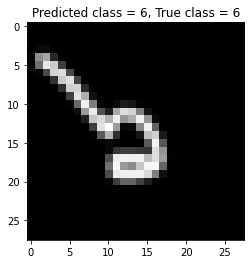

In [21]:
# Show some random images with their predicted number
sample_path = glob("data/validation/*/*.png")[50]
img = Image.open(sample_path)
img = (1 - transform(img)).squeeze(0)
pred = net(img)
pred = int(pred.argmax(dim=1))
true_class = Path(sample_path).parent.name

plt.title("Predicted class = {}, True class = {}".format(pred, true_class))
plt.imshow(img, cmap="gray")
plt.show()

## **Train neural netowrk model with more layers**

In [22]:
# TODO: Create neural network with more layers
class ThaiDigitMoreLayers(nn.Module):
    def __init__(self):
        super(ThaiDigitMoreLayers, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 392)
        self.fc2 = nn.Linear(392, 196)
        self.fc3 = nn.Linear(196, 98)
        self.fc4 = nn.Linear(98, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        return x

In [23]:
n_epochs = 100

more_layers_model = ThaiDigitMoreLayers()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(more_layers_model.parameters(), lr=0.01)

more_layers_model, more_layers_model_history = train(
    more_layers_model, n_epochs, loss_fn, optimizer, train_loader, val_loader
)

--------------------------------------------------------------------------------
Epochs 1   train loss 2.30395 train acc 0.09397 val loss 2.30732 val acc 0.09714
--------------------------------------------------------------------------------
Epochs 2   train loss 2.30233 train acc 0.09905 val loss 2.30559 val acc 0.10286
--------------------------------------------------------------------------------
Epochs 3   train loss 2.30031 train acc 0.11683 val loss 2.30406 val acc 0.10286
--------------------------------------------------------------------------------
Epochs 4   train loss 2.29873 train acc 0.10540 val loss 2.30255 val acc 0.10857
--------------------------------------------------------------------------------
Epochs 5   train loss 2.29696 train acc 0.13016 val loss 2.30101 val acc 0.13714
--------------------------------------------------------------------------------
Epochs 6   train loss 2.29505 train acc 0.15746 val loss 2.29910 val acc 0.16571
----------------------------

In [24]:
pred_df = evaluate("data/validation/", more_layers_model)
pred_df.head(3)

Accuracy: 73.71%


,path,prediction,label
0,data/validation/8/d86d0ca1-d4cb-48e9-aa8a-6c0f...,8,8
1,data/validation/8/23_6db9fc09-96ed-44a9-8052-c...,8,8
2,data/validation/8/1e7a0e6c-9b02-434c-bf88-6d60...,8,8


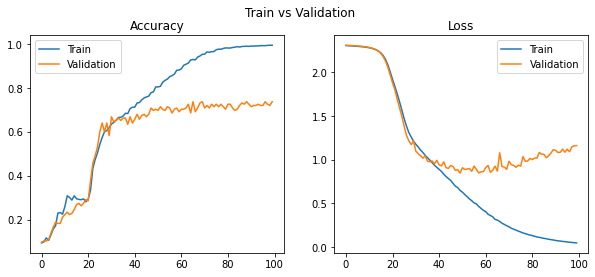

In [25]:
plot_graph(more_layers_model_history)

The training accuracy of the model is higher than the validation accuracy.
This means that the model is overfitting the training data.
We can try to reduce the overfitting by adding regularization .

## **Regularization with Dropout**

Dropout is one of the techniques used to prevent overfitting. Here, we can train the model for more epochs to observe the loss curve.

In [26]:
# TODO: Add Dropout layer to the previous neural network
class DropoutThaiDigit(nn.Module):
    def __init__(self):
        super(DropoutThaiDigit, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 392)
        self.fc2 = nn.Linear(392, 196)
        self.fc3 = nn.Linear(196, 98)
        self.fc4 = nn.Linear(98, 10)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc4(x)
        return x

In [27]:
n_epochs = 100
drop_model = DropoutThaiDigit()  # Initialize a model
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(drop_model.parameters(), lr=0.01)

dropout_model, dropout_model_history = train(drop_model, n_epochs, loss_fn, optimizer, train_loader, val_loader)

--------------------------------------------------------------------------------
Epochs 1   train loss 2.30361 train acc 0.10159 val loss 2.30448 val acc 0.09714
--------------------------------------------------------------------------------
Epochs 2   train loss 2.30232 train acc 0.11429 val loss 2.30329 val acc 0.10857
--------------------------------------------------------------------------------
Epochs 3   train loss 2.30091 train acc 0.11810 val loss 2.30231 val acc 0.12000
--------------------------------------------------------------------------------
Epochs 4   train loss 2.29936 train acc 0.12635 val loss 2.30130 val acc 0.12571
--------------------------------------------------------------------------------
Epochs 5   train loss 2.29798 train acc 0.13587 val loss 2.30019 val acc 0.14286
--------------------------------------------------------------------------------
Epochs 6   train loss 2.29621 train acc 0.13460 val loss 2.29872 val acc 0.13143
----------------------------

In [28]:
pred_df = evaluate("data/validation/", dropout_model)
pred_df.head(3)

Accuracy: 74.86%


,path,prediction,label
0,data/validation/8/d86d0ca1-d4cb-48e9-aa8a-6c0f...,8,8
1,data/validation/8/23_6db9fc09-96ed-44a9-8052-c...,8,8
2,data/validation/8/1e7a0e6c-9b02-434c-bf88-6d60...,8,8


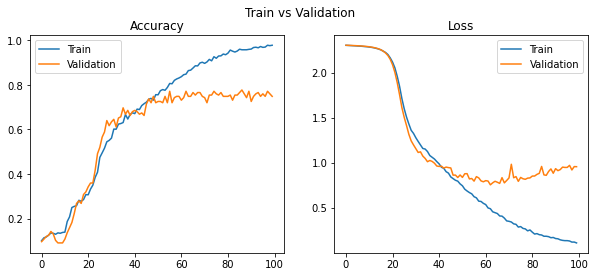

In [29]:
plot_graph(dropout_model_history)

Now the gap between the training accuracy and validation accuracy is smaller than before.

## **Image Augmentation**

Image augmentation is a technique used to artificially increase the size of a training dataset by creating modified versions of existing images.

In [30]:
# TODO: Add image augmentation in `train_transform`
train_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    # add here
    transforms.RandomAffine(degrees=(-10, 10), translate=(0.0, 0.1), scale=(1, 1)),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.ToTensor(),
])

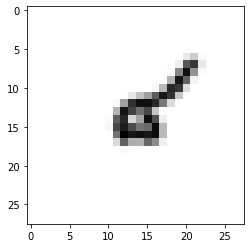

In [31]:
# TODO: Transform image using `train_transform`

# Example of augmented image
path = glob("deep-learning-skooldio/thai-handwritten-dataset/*/*")[20]
img = Image.open(path)

tranformed_img = train_transform(img).squeeze(0)
plt.imshow(tranformed_img, cmap="gray")
plt.show()

In [32]:
train_thaidigit_dataset = ThaiDigitDataset("data/train/", transform=train_transform)
val_thaidigit_dataset = ThaiDigitDataset("data/validation/", transform=val_transform)

In [33]:
train_dataloader = DataLoader(train_thaidigit_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_thaidigit_dataset, batch_size=16, shuffle=False)

In [34]:
# Let's train the model with augmented data
n_epochs = 150
augmented_model = DropoutThaiDigit()  # Initialize the model
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(augmented_model.parameters(), lr=0.01)

augmented_model, augmented_model_history = train(
    augmented_model, n_epochs, loss_fn, optimizer, train_dataloader, val_dataloader
)

--------------------------------------------------------------------------------
Epochs 1   train loss 2.30205 train acc 0.11619 val loss 2.30530 val acc 0.08571
--------------------------------------------------------------------------------
Epochs 2   train loss 2.30167 train acc 0.11429 val loss 2.30434 val acc 0.12571
--------------------------------------------------------------------------------
Epochs 3   train loss 2.30066 train acc 0.12825 val loss 2.30355 val acc 0.14857
--------------------------------------------------------------------------------
Epochs 4   train loss 2.29967 train acc 0.13587 val loss 2.30247 val acc 0.14857
--------------------------------------------------------------------------------
Epochs 5   train loss 2.29893 train acc 0.13460 val loss 2.30122 val acc 0.16000
--------------------------------------------------------------------------------
Epochs 6   train loss 2.29808 train acc 0.14667 val loss 2.30006 val acc 0.18286
----------------------------

In [35]:
# Evaluate the new model with old dataset.
pred_df = evaluate("data/validation/", augmented_model)
pred_df.head(3)

Accuracy: 80.00%


,path,prediction,label
0,data/validation/8/d86d0ca1-d4cb-48e9-aa8a-6c0f...,8,8
1,data/validation/8/23_6db9fc09-96ed-44a9-8052-c...,8,8
2,data/validation/8/1e7a0e6c-9b02-434c-bf88-6d60...,8,8


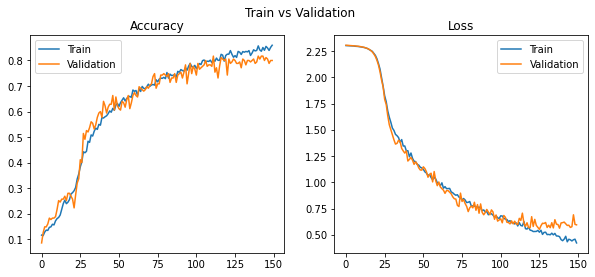

In [36]:
plot_graph(augmented_model_history)

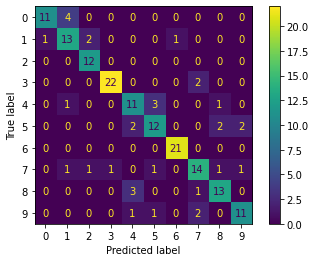

In [37]:
# Confusion matrix
cm = confusion_matrix(pred_df.label, pred_df.prediction, labels=range(10))
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
display.plot()
plt.show()